### Importing Libraries

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
%matplotlib inline

### Importing Data and Data Manipulation

In [233]:
# Read in all tables
# Concat all tables

tweets = pd.read_csv('tweets.csv', encoding='iso-8859-1')
steven_gpt_tweets = pd.read_csv('chatgpt_tweets.csv')
maddie_gpt_tweets = pd.read_csv('cg_tweets_final.csv')


In [234]:
tweets.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [235]:
tweets.rename(
    columns={
        'emotion_in_tweet_is_directed_at': 'brand',
        'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
    },
    inplace=True)

tweets.head(2)

,tweet_text,brand,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion


In [236]:
steven_gpt_tweets.columns

Index(['Tweets'], dtype='object')

In [237]:
# Renaming columns to prepare for concatenation
steven_gpt_tweets.rename(columns={'Tweets': 'tweet_text'}, inplace=True)

# Adding columns with brand and emotion as all 'Apple' and 'Negative emotion', respectively
steven_gpt_tweets['brand'] = 'Apple'
steven_gpt_tweets['emotion'] = 'Negative emotion'

steven_gpt_tweets.head(2)

,tweet_text,brand,emotion
0,Apple's desperation for attention is evident w...,Apple,Negative emotion
1,Barry Diller's thoughts on iPad-only content s...,Apple,Negative emotion


In [238]:
maddie_gpt_tweets.columns

Index(['Tweet ', 'Emotion'], dtype='object')

In [239]:
# Renaming columns to prepare for concatenation
maddie_gpt_tweets.rename(
    columns={
        'Tweet ': 'tweet_text',
        'Emotion': 'emotion'
    },
    inplace=True
)

# Adding column with brand as all 'Apple'
maddie_gpt_tweets['brand'] = 'Apple'

# Changing the order of columns to match other tweet dataframes
maddie_gpt_tweets = maddie_gpt_tweets[['tweet_text', 'brand', 'emotion']]


maddie_gpt_tweets.head(2)

,tweet_text,brand,emotion
0,"""No NFC in the iPhone 5 at #SXSW due to Apple'...",Apple,Negative
1,"""Barry Diller's not holding back, openly criti...",Apple,Negative


In [240]:
# Combining all of our dataframes into 1
all_tweets = pd.concat([tweets, steven_gpt_tweets, maddie_gpt_tweets], ignore_index=True)

print(f"Number of Tweets with duplicates: {len(all_tweets)}")

# Dropping duplicated tweets that were generated from ChatGPT
all_tweets.drop_duplicates(subset=['tweet_text'], inplace=True)
print(f"Number of Tweets without duplicates: {len(all_tweets)}")


apple_tweets = all_tweets.copy()

# Dictionary to convert apple products to just 'Apple'
apple_products = {'iPad': 'Apple',
                  'Apple': 'Apple',
                  'iPad or iPhone App': 'Apple',
                  'iPhone': 'Apple',
                  'Other Apple product or service': 'Apple'}

# Convert all Apple products to just 'Apple'
apple_tweets['brand'] = apple_tweets['brand'].map(apple_products)

# Analyze tweets where the emotions were only positive or negative
apple_tweets = apple_tweets.loc[
    (apple_tweets['emotion']=='Positive emotion') | 
    (apple_tweets['emotion']=='Negative emotion') | 
    (apple_tweets['emotion']=='Negative')]


# Dictioanry to convert emotions to binary 0's and 1's
numeric_emotion = {
    'Negative': 1,
    'Negative emotion': 1,
    'Positive': 0,
    'Positive emotion': 0}

# Convert all positive and negative emotions to 1 and 0, respectively
apple_tweets['emotion'] = apple_tweets['emotion'].map(numeric_emotion)


apple_tweets['emotion'].value_counts(normalize=True)


Number of Tweets with duplicates: 10406
Number of Tweets without duplicates: 10049


0    0.656637
1    0.343363
Name: emotion, dtype: float64

### Exploratory Data Analysis (EDA)

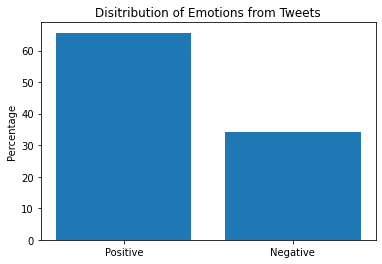

In [241]:
# Finding the distribution of emotion for tweets
emotion = apple_tweets['emotion'].value_counts(normalize=True)

fig, ax = plt.subplots()
ax.bar(x=['Positive', 'Negative'], height=emotion*100)

ax.set_title('Disitribution of Emotions from Tweets');
ax.set_ylabel('Percentage');

<ipython-input-242-21c99d3c68e0>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emotion.index, rotation=-35, ha='left')


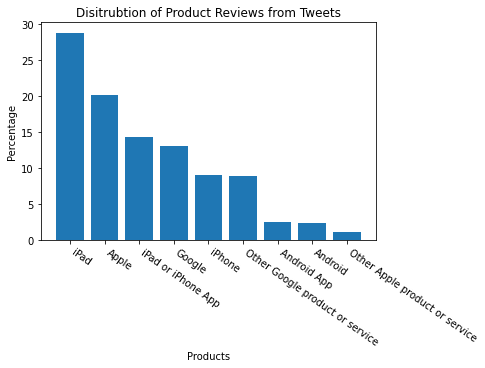

In [242]:
emotion = tweets['brand'].value_counts(normalize=True)

fig, ax = plt.subplots()

ax.bar(x=emotion.index, height=emotion*100)
ax.set_xticklabels(emotion.index, rotation=-35, ha='left')
ax.set_xlabel('Products')
ax.set_ylabel('Percentage')
ax.set_title('Disitrubtion of Product Reviews from Tweets');

### Term Frequency - Inverse Document Frequency (TF-IDF)


In [243]:
X = apple_tweets['tweet_text']
y = apple_tweets['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [244]:
# Tokenizer
pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(pattern)

# Stop words list
stopwords_list = stopwords.words('english')

additional_stopwords = ['sxsw', 'sxswi', 'austin']
apple_related_terms = ['app', 'apps', 'apple', 'ipad', 'ipad2', 'iphone']
stopwords_list.extend(additional_stopwords)
stopwords_list.extend(apple_related_terms)

def tokenize(document):
    tokens = tokenizer.tokenize(document)
    return tokens

tfidf = TfidfVectorizer(
    max_features = 20,
    stop_words = stopwords_list,
    tokenizer = tokenize)

X_train_vectorized = tfidf.fit_transform(X_train)

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())


,amp,android,circles,get,google,great,launch,like,line,link,mention,new,one,people,pop,quot,rt,social,store,time
0,0.607372,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.286379,0.000000,0.634213,0.0,0.0,0.0,0.383223,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0.806587,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.452530,0.380309,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.000000,0.481912,0.0,0.484852,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.400708,0.000000,0.0,0.0,0.0,0.000000,0.0,0.350793,0.499055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,0.000000,0.601516,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500158,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.622913
3386,0.000000,0.000000,0.0,0.000000,0.81352,0.0,0.0,0.0,0.0,0.337384,0.283540,0.000000,0.000000,0.0,0.0,0.0,0.379424,0.0,0.000000,0.000000
3387,0.785573,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.370401,0.000000,0.000000,0.0,0.0,0.0,0.495659,0.0,0.000000,0.000000
3388,0.000000,0.000000,0.0,0.000000,1.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


### Random Forest Classifer Model

In [279]:
# Random Forest Classifier Modelling
rf = RandomForestClassifier(
    n_estimators = 10, # number of decision trees
    criterion = 'gini',
    max_depth = 5, # the max depth of each decision tree
    random_state = 42
)

rf.fit(X_train_vectorized, y_train) # fit the model onto the train features
y_train_pred = rf.predict(X_train_vectorized) # predicted train target values from model

print(f"Train Recall: {recall_score(y_train, y_train_pred)}") # recall score for train data

Train Recall: 0.6967353951890034


In [280]:
X_test_vectorized = tfidf.transform(X_test) # tf-idf transform the test features
y_test_pred = rf.predict(X_test_vectorized) # predicted test target values from model

print(f"Test Recall: {recall_score(y_test, y_test_pred)}") # recall score for test targets


Test Recall: 0.6649484536082474
